## 期末大作业
 2151406 刘卓明
 专业：人工智能


### 一.题目
利用提供的银行客户信息对客户是否会定期存款进行二分类预测

### 二.思路
首先对数据集进行分析，然后对数据集进行预处理，然后通过构建线性回归、决策树、随机森林等机器学习模型进行训练，比较得到表现较好的模型后，针对该模型进行调优，得到最好的二分类结果；同时构建简单的神经网络进行训练，与机器学习的最优模型进行对比

### 三.具体过程 

#### 第一步 导入所需要的包
导入所需要的包，这里主要需要的是sklearn库中的包用来进行数据处理和搭建机器学习相关模型，matplotlib，seaborn主要用于可视化一些结果，pandas库用于将csv类型的数据读入为pandas类型进行处理，numpy用于处理数组相关的数据

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from scipy.stats import norm
from sklearn import decomposition
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

#### 第二步 分析数据集，观察各个特征（属性）的分布情况以及各个特征之间的相关性

In [2]:
data = pd.read_csv("train.csv",header=0,delimiter = ",")
data.shape

(13207, 21)

观察数据的具体信息

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13207 entries, 0 to 13206
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             13207 non-null  int64  
 1   job             13207 non-null  object 
 2   marital         13207 non-null  object 
 3   education       13207 non-null  object 
 4   default         13207 non-null  object 
 5   housing         13207 non-null  object 
 6   loan            13207 non-null  object 
 7   contact         13207 non-null  object 
 8   month           13207 non-null  object 
 9   day_of_week     13207 non-null  object 
 10  duration        13207 non-null  int64  
 11  campaign        13207 non-null  int64  
 12  pdays           13207 non-null  int64  
 13  previous        13207 non-null  int64  
 14  poutcome        13207 non-null  object 
 15  emp.var.rate    13207 non-null  float64
 16  cons.price.idx  13207 non-null  float64
 17  cons.conf.idx   13207 non-null 

绘制各个特征分布的情况

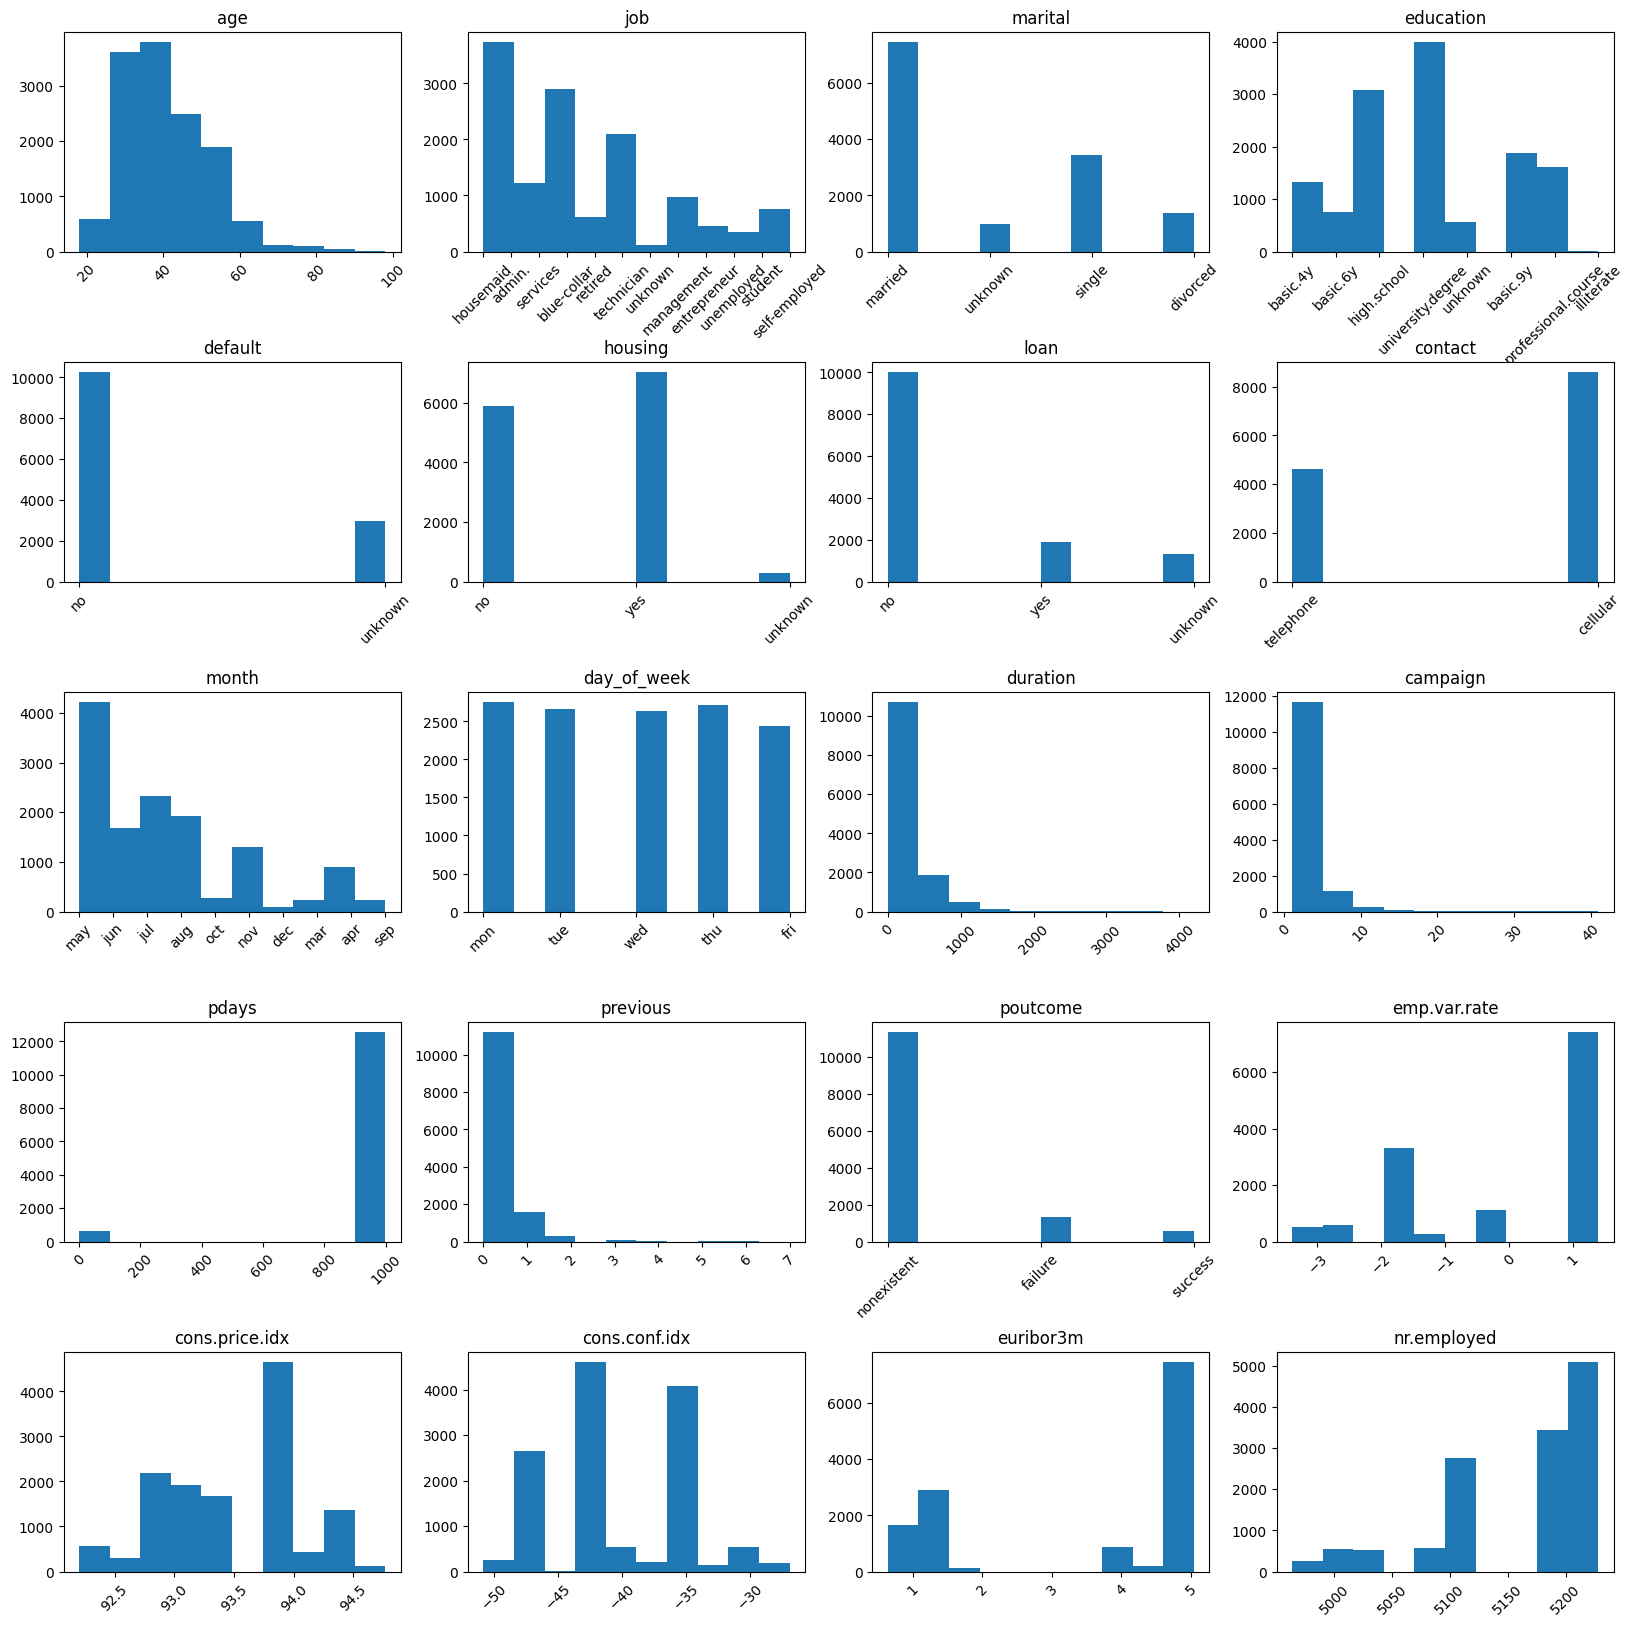

In [4]:
# 取出特征和target
features = data.iloc[:, :-1]
target = data.iloc[:, -1]
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)
for i, column in enumerate(features.columns):
    # 计算位置
    row = i // 4
    col = i % 4
    # 绘制直方图
    ax[row, col].hist(features[column])
    # 加标题
    ax[row, col].set_title(column)   
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.show()

这里可以从直方图里看出，对于default列，它的值只有no和unknown两种，显然这个特征对于模型来说是毫无意义的，因此我们在数据集中删去这列；而对于pdays，其要么是999，要么是处于0-10之间的极小值，和default情况类似，同样考虑删去该列（后续对是否删除进行对比）。

In [5]:
# fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
# fig.subplots_adjust(hspace=0.5)

# # 绘制饼图
# for i, column in enumerate(features.columns):
#     row = i // 4
#     col = i % 4
#     # 计算各个值的数量
#     counts = features[column].value_counts()
#     # 取得数量和标签
#     labels = counts.index
#     sizes = counts.values
#     # 绘制饼图
#     ax[row, col].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
#     ax[row, col].set_title(column)

# # 调整子图的布局，确保标签不重叠
# plt.tight_layout()
# plt.show()

绘制相关关系图

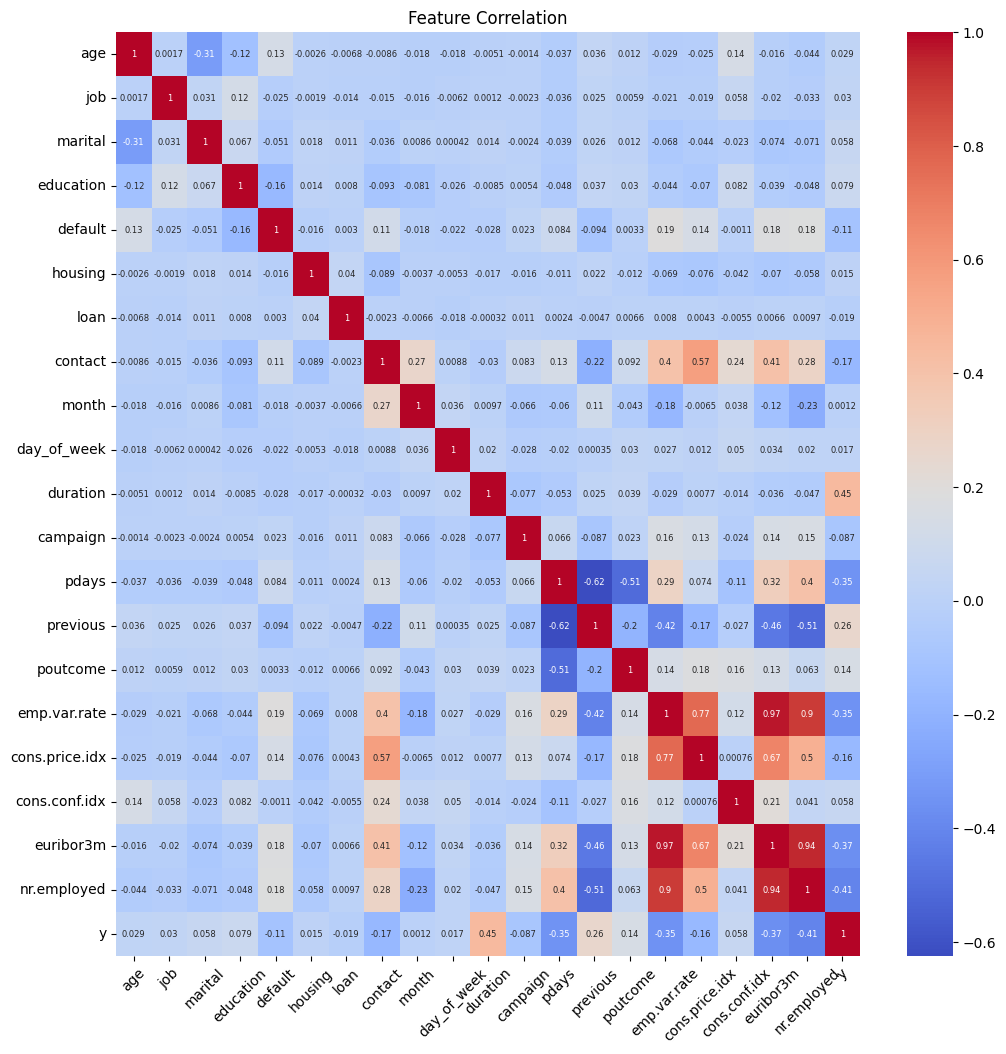

In [6]:
features_old = data.iloc[:,:]
for column in features_old.columns:
    if features_old[column].dtype == 'object':
        features_old[column] = features_old[column].astype('category').cat.codes
# 计算特征相关性矩阵
correlation_matrix = features_old.corr()
# 创建特征相关性热力图
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True,annot_kws={'size': 6})
plt.title('Feature Correlation')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

从热力图可以看出month选项的相关系数比较小，也可以考虑去除

#### 第三步 读入并创建数据集，包括训练集、验证集、测试集，同时对数据进行初步处理

In [7]:
# 读入数据
train_data=pd.read_csv("train.csv", header = 0, delimiter = ",")
val_X_data=pd.read_csv("val.csv", header = 0, delimiter = ",")
val_y_data=pd.read_csv("val_groundtruth.csv", header = 0, delimiter = ",")
test_X_data=pd.read_csv("test.csv", header = 0, delimiter = ",")



# # 数据初步处理
# train_data = train_data.drop(columns=['default'])
# val_X_data = val_X_data.drop(columns=['default'])
# 删除三列的情况
# 这里相比起汇报时候多去除了一列，共去除了三个特征
train_data = train_data.drop(columns=['default','pdays','month'])
val_X_data = val_X_data.drop(columns=['default','pdays','month'])
test_X_data = test_X_data.drop(columns=['default','pdays','month'])
# 训练集
train_X = train_data.iloc[:, :-1]
# 标签是最后一列
train_y = train_data.iloc[:, -1]

# 验证集
# 特征是第一列之后的所有列
val_X = val_X_data.iloc[:,1:]
val_y = val_y_data.iloc[:, -1]

# 测试集

test_X = test_X_data.iloc[:, 1:]

In [8]:
# 查看训练集信息
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13207 entries, 0 to 13206
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             13207 non-null  int64  
 1   job             13207 non-null  object 
 2   marital         13207 non-null  object 
 3   education       13207 non-null  object 
 4   housing         13207 non-null  object 
 5   loan            13207 non-null  object 
 6   contact         13207 non-null  object 
 7   day_of_week     13207 non-null  object 
 8   duration        13207 non-null  int64  
 9   campaign        13207 non-null  int64  
 10  previous        13207 non-null  int64  
 11  poutcome        13207 non-null  object 
 12  emp.var.rate    13207 non-null  float64
 13  cons.price.idx  13207 non-null  float64
 14  cons.conf.idx   13207 non-null  float64
 15  euribor3m       13207 non-null  float64
 16  nr.employed     13207 non-null  float64
dtypes: float64(5), int64(4), object

这里可以看出1-8，12列的变量类型是object(结合数据集具体的内容可以知道基本是文字类别，比如说对于第1列，是job，那么不同的类别代表的就是不同的工作，这里适合用独热编码来给予他们数字编码),其他列是float和int类型，但是数据的分布范围很不均衡，适合进行标准化处理

In [9]:
#  查看验证集信息
val_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2528 non-null   int64  
 1   job             2528 non-null   object 
 2   marital         2528 non-null   object 
 3   education       2528 non-null   object 
 4   housing         2528 non-null   object 
 5   loan            2528 non-null   object 
 6   contact         2528 non-null   object 
 7   day_of_week     2528 non-null   object 
 8   duration        2528 non-null   int64  
 9   campaign        2528 non-null   int64  
 10  previous        2528 non-null   int64  
 11  poutcome        2528 non-null   object 
 12  emp.var.rate    2528 non-null   float64
 13  cons.price.idx  2528 non-null   float64
 14  cons.conf.idx   2528 non-null   float64
 15  euribor3m       2528 non-null   float64
 16  nr.employed     2528 non-null   float64
dtypes: float64(5), int64(4), object(8

In [10]:
# 查看测试集信息
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10701 entries, 0 to 10700
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             10701 non-null  int64  
 1   job             10701 non-null  object 
 2   marital         10701 non-null  object 
 3   education       10701 non-null  object 
 4   housing         10701 non-null  object 
 5   loan            10701 non-null  object 
 6   contact         10701 non-null  object 
 7   day_of_week     10701 non-null  object 
 8   duration        10701 non-null  int64  
 9   campaign        10701 non-null  int64  
 10  previous        10701 non-null  int64  
 11  poutcome        10701 non-null  object 
 12  emp.var.rate    10701 non-null  float64
 13  cons.price.idx  10701 non-null  float64
 14  cons.conf.idx   10701 non-null  float64
 15  euribor3m       10701 non-null  float64
 16  nr.employed     10701 non-null  float64
dtypes: float64(5), int64(4), object

#### 第四步 数据编码（独热编码，标准化）共采用了两种编码形式，对于数字类型的进行标准化编码，对于object类型的进行独热编码


In [11]:
def Encoding(data):    
    pre_process_data= make_column_transformer(
      (OneHotEncoder(), [1,2,3,4,5,6,7,11]),
      (StandardScaler(), [0,8,9,10,12,13,14,15,16])
       )
    data_encode = pre_process_data.fit_transform(data)
    return data_encode

train_X=Encoding(train_X)
val_X=Encoding(val_X)
train_y=train_y.values.tolist()
val_y=val_y.values.tolist()
test_X = Encoding(test_X)

#### 第五步 分类器选择以及进一步的数据处理

In [12]:
# 训练超参数设置

# 分类器设置
classifiers = [
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
]

# 迭代次数设置
iteration_time = 20
classifiers_num = len(classifiers)


SMOTE过采样平衡数据集的方法

In [13]:
#SMOTE过采样平衡数据集
def my_smote(features,labels):
    model = SMOTE()  
    return model.fit_resample(features, labels)

#### 第六步 训练及调优
训练以及调优的过程

##### 6.1 直接进行训练的过程

In [14]:
f1_scores = np.zeros((len(classifiers), iteration_time))
# 遍历分类器并进行分类及性能评估
for i, classifier in enumerate(classifiers):
    classifier_name = type(classifier).__name__
    for j in range(iteration_time):
        # 使用训练集进行训练
        classifier.fit(train_X, train_y)  
        # 预测值
        y_pred = classifier.predict(val_X)  
        # 真值
        y_true=val_y
        score = f1_score(
        y_true, 
        y_pred,
        labels=["yes","no"],
        average='macro'
        )
        f1_scores[i, j] = score
    avg_f1_score = np.mean(f1_scores[i])
    print(f"{classifier_name}: Average F1 score = {avg_f1_score:.4f}")

/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

LogisticRegression: Average F1 score = 0.7967
SVC: Average F1 score = 0.8070
DecisionTreeClassifier: Average F1 score = 0.7803
RandomForestClassifier: Average F1 score = 0.8199
AdaBoostClassifier: Average F1 score = 0.7835
KNeighborsClassifier: Average F1 score = 0.7685


这里可以看出效果最好的是随机森林，次好的是SVC，其他几种效果差不多

##### 6.2 进行PCA降维的过程

In [15]:
# # 针对数据进行pca降维来减少特征的维度
train_X_pca = train_X
val_X_pca = val_X
model=decomposition.PCA(n_components=10)
model.fit(train_X_pca)
model.fit(val_X_pca)
train_X_pca=model.transform(train_X_pca)
val_X_pca=model.transform(val_X_pca)

In [16]:
train_X_pca.shape

(13207, 10)

In [17]:
f1_scores = np.zeros((len(classifiers), iteration_time))
# 遍历分类器并进行分类及性能评估
for i, classifier in enumerate(classifiers):
    classifier_name = type(classifier).__name__
    for j in range(iteration_time):
        # 使用训练集进行训练
        classifier.fit(train_X_pca, train_y)  
        # 预测值
        y_pred = classifier.predict(val_X_pca)  
        # 真值
        y_true=val_y
        score = f1_score(
        y_true, 
        y_pred,
        labels=["yes","no"],
        average='macro'
        )
        f1_scores[i, j] = score
    avg_f1_score = np.mean(f1_scores[i])
    print(f"{classifier_name}: Average F1 score = {avg_f1_score:.4f}")

LogisticRegression: Average F1 score = 0.7719
SVC: Average F1 score = 0.8007
DecisionTreeClassifier: Average F1 score = 0.7489
RandomForestClassifier: Average F1 score = 0.8080
AdaBoostClassifier: Average F1 score = 0.7659
KNeighborsClassifier: Average F1 score = 0.7753


这里可以看出降维后，效果最好的仍然是svc和随机森林，但是score都有所下降，所以决定不进行pca降维；当然如果在有巨大的计算开销的时候，使用pca降维可以减少开销

In [60]:
# 使用网格化搜索的方法进行调优的函数
def parameter_tuning(train_X,train_y,val_X,val_y):
    model = RandomForestClassifier(random_state=25)
    parameters = {
        'n_estimators': [50, 100,200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 3]
    }
    model_search= GridSearchCV(model, parameters, cv=5)
    model_search.fit(train_X, train_y)
    print("Best Parameters: ", model_search.best_params_)
    print("Train F1 Score: ", f1_score(train_y, model_search.predict(train_X), labels=["yes","no"],average='macro'))
    print("Val F1 Score: ", f1_score(val_y, model_search.predict(val_X), labels=["yes","no"],average='macro'))
    return model_search.best_params_

##### 6.3 进行过smote过采样之后进行训练的过程

In [19]:
train_X_smote,train_y_smote=my_smote(train_X,train_y)
val_X_smote = val_X
test_X_smote = test_X
val_y_smote = val_y

In [20]:
f1_scores = np.zeros((len(classifiers), iteration_time))
# 遍历分类器并进行分类及性能评估
for i, classifier in enumerate(classifiers):
    classifier_name = type(classifier).__name__
    for j in range(iteration_time):
        # 使用训练集进行训练
        classifier.fit(train_X_smote, train_y_smote)  
        # 预测值
        y_pred = classifier.predict(val_X_smote)  
        # 真值
        y_true=val_y
        score = f1_score(
        y_true, 
        y_pred,
        labels=["yes","no"],
        average='macro'
        )
        f1_scores[i, j] = score
    avg_f1_score = np.mean(f1_scores[i])
    print(f"{classifier_name}: Average F1 score = {avg_f1_score:.4f}")

/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

LogisticRegression: Average F1 score = 0.8065
SVC: Average F1 score = 0.8049
DecisionTreeClassifier: Average F1 score = 0.6851
RandomForestClassifier: Average F1 score = 0.7676
AdaBoostClassifier: Average F1 score = 0.7727
KNeighborsClassifier: Average F1 score = 0.7752


从结果可以看出几种算法效果都有所下降，说明过采样发挥作用不好所以下面对随机森林进行调参得到最优参数

In [ ]:
parameter_tuning(train_X,train_y,val_X,val_y)

这里有一定概率得到的不是最优解，暂时没有找到原因

##### 6.4神经网络方法

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
# from kan import KAN


# Convert labels to numeric values
label_mapping = {'yes': 1, 'no': 0}
print("asd")
train_y_numeric = [1 if x == 'yes' else 0 for x in train_y]
val_y_numeric = [1 if x == 'yes' else 0 for x in val_y]
print("asddasd")
# Convert data to PyTorch tensors
train_X_tensor = torch.FloatTensor(train_X)
train_y_tensor = torch.LongTensor(train_y_numeric)  # Assuming labels are now integers (0 and 1)
val_X_tensor = torch.FloatTensor(val_X)
val_y_tensor = torch.LongTensor(val_y_numeric)  # Assuming labels are now integers (0 and 1)

# Define your neural network model using PyTorch
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        # self.kan = KAN(width=[16,8,32], grid=5, k=3, seed=0,device="cuda")
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = NeuralNetwork()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of iterations
num_iterations = 3000
best_f1_score = 0.0
best_model_state = None

# Training loop
for j in range(num_iterations):
    # Train the model
    model.train()
    optimizer.zero_grad()
    outputs = model(train_X_tensor)
    loss = criterion(outputs.squeeze(), train_y_tensor.float())  # Assuming train_y is 1D tensor
    loss.backward()
    optimizer.step()
    
    # Evaluate on validation set and calculate F1 score
    model.eval()
    with torch.no_grad():
        predicted = model(val_X_tensor)
        predicted_labels = (predicted > 0.5).float().squeeze().numpy()  # Convert predictions to numpy array
        f1 = f1_score(val_y_numeric, predicted_labels, labels=[0, 1], average='macro')  # Calculate F1 score
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_model_state = model.state_dict()
            
            
if best_model_state is not None:
    torch.save(best_model_state, 'best_model.pth')
    print("Best model saved successfully.")


print(f"Best F1 score on validation set: {best_f1_score:.4f}")           

asd
asddasd
Best model saved successfully.
Best F1 score on validation set: 0.8183


上面是搭建神经网络进行训练的过程，如果设置不同的随机数种子会有不同的结果，波动范围较大，效果较一般（之前少去除一列时候效果较好）

In [53]:
model = NeuralNetwork()
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
val_X_tensor = torch.FloatTensor(val_X)
test_X_tensor = torch.FloatTensor(test_X)
val_y_numeric = [1 if x == 'yes' else 0 for x in val_y]
val_y_tensor = torch.LongTensor(val_y_numeric)
with torch.no_grad():
    predicted = model(val_X_tensor)
    predicted_labels = (predicted > 0.5).float().squeeze().numpy()  # 将预测结果转换为numpy数组

# 计算F1分数
val_score = f1_score(val_y_numeric, predicted_labels, labels=[0, 1], average='macro')
print(f"验证集F1_score:: {val_score:.4f}")



with torch.no_grad():
    y_test_pred = model(test_X_tensor)
    y_test_pred = (y_test_pred > 0.5).float().squeeze().numpy().tolist()

# 写入CSV文件
with open("test_pred_nerual.csv", mode='w', newline='') as file:
    writer = csv.writer(file)

    # 写入表头
    writer.writerow(["SampleId", "y"])

    # 写入数据
    for i, value in enumerate(y_test_pred):
        writer.writerow([i, 'yes' if value == 1 else 'no'])
print("成功生成test_pred_nerual.csv文件")

验证集F1_score:: 0.8017
成功生成test_pred_nerual.csv文件


In [59]:
# 这里网格搜索的最优min_samples_spilt为6
model = RandomForestClassifier(random_state=25,
                             max_depth= 15,
                             min_samples_leaf=1,
                             min_samples_split=6,
                             n_estimators= 200)
# model = model.fit(train_X_smote,train_y_smote)
model = model.fit(train_X,train_y)
#预测验证集真实结果
y_val_pred=model.predict(val_X).tolist()
y_val_true=val_y


#得到验证集F1_score
val_score=f1_score(
        y_val_true, 
        y_val_pred,
        labels=["yes","no"],
        average='macro'
)
print("验证集F1_score:",val_score)
#预测测试集真实结果并生成test_pred.csv
y_test_pred=model.predict(test_X).tolist()
# 写入CSV文件
test_file="test_pred_rf.csv"
with open(test_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # 写入表头
    writer.writerow(["SampleId", "y"])

    # 写入数据
    for i, value in enumerate(y_test_pred):
        writer.writerow([i, value])
print("成功生成pred_test_rf.csv文件")


验证集F1_score: 0.8307997074257385
成功生成pred_test_rf.csv文件


#### 第七步 最终结果导出

这里得出结果还是随机森林比较好，最终选择随机森林模型，完整生成pred_test.csv和pred_val.csv的过程如下：

In [62]:
model = RandomForestClassifier(random_state=25,
                               max_depth=15,
                               min_samples_leaf=1,
                               min_samples_split=6,
                               n_estimators=200)

# 使用训练集数据拟合模型
model.fit(train_X, train_y)

# 预测验证集真实结果
y_val_pred = model.predict(val_X).tolist()
y_val_true = val_y

# # 计算验证集F1分数
# val_score = f1_score(y_val_true, y_val_pred, labels=["yes", "no"], average='macro')
# print("验证集F1_score:", val_score)

# 这里计算分数在F1-score.ipynb中进行
# 写入验证集预测结果到 val_pred_rf.csv
val_file = "val_pred.csv"
with open(val_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # 写入表头
    writer.writerow(["SampleId", "y"])

    # 写入数据
    for i, value in enumerate(y_val_pred):
        writer.writerow([i, value])

print("成功生成 val_pred.csv 文件")

# 预测测试集真实结果并生成 test_pred.csv
y_test_pred = model.predict(test_X).tolist()

# 写入测试集预测结果到 test_pred.csv
test_file = "test_pred.csv"
with open(test_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # 写入表头
    writer.writerow(["SampleId", "y"])

    # 写入数据
    for i, value in enumerate(y_test_pred):
        writer.writerow([i, value])

print("成功生成 test_pred.csv 文件")


成功生成 val_pred.csv 文件
成功生成 test_pred.csv 文件


在F1_score.ipynb测试后，最优结果为0.8307997074257385